In [1]:
# load and the test weekly fpl scrape
season="2019-20"
gw=22
model_type="rf"

In [2]:
import os
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
%matplotlib inline
import pickle
from sklearn.feature_selection import SelectFromModel

In [3]:
os.chdir(os.path.join(os.getcwd(), "..", "..", "data"));

In [4]:
random_state = np.random.seed(24)

In [5]:
X_train = pd.read_csv("x-train.csv");
X_test = pd.read_csv("x-test.csv");
X_val = pd.read_csv("x-val.csv");

In [6]:
y_train = pd.read_csv("y-train.csv");
y_test = pd.read_csv("y-test.csv");
y_val = pd.read_csv("y-val.csv");

In [7]:
# parameters = {
#     'n_estimators': [400, 800, 1600], 
#     'max_depth': [16],
#     'min_samples_split': [8],
#     'min_samples_leaf': [64],
#     'max_leaf_nodes': [2, 4, 8, 16],
#     'oob_score': [True, False]
# }
parameters = {
    'n_estimators': [100], 
    'max_depth': [16],
    'min_samples_split': [8],
    'min_samples_leaf': [64],
    'oob_score': [True]
}
# {'max_depth': 16,
#  'min_samples_leaf': 64,
#  'min_samples_split': 8,
#  'n_estimators': 100}

In [8]:
regressor = RandomForestRegressor(random_state=random_state, n_jobs=-1)

In [9]:
clf = GridSearchCV(regressor, parameters, scoring='r2', cv=5, n_jobs=-1, verbose=5)

In [10]:
clf.fit(X_train, y_train)  

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   31.3s remaining:   46.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.4s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:741: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [11]:
clf.best_params_

{'max_depth': 16,
 'min_samples_leaf': 64,
 'min_samples_split': 8,
 'n_estimators': 100,
 'oob_score': True}

In [12]:
clf.best_score_

0.3041299315414728

In [13]:
regressor = clf.best_estimator_

In [14]:
y_pred = regressor.predict(X_test)

In [15]:
def getInRange(actual, predicted, lower_bound=0, upper_bound=1):
    return ((actual - predicted) >= lower_bound) and ((actual - predicted) <= upper_bound)

In [16]:
pred_df = pd.DataFrame({'Actual': np.array(y_test).flatten(), 'Predicted': y_pred.flatten()})

In [17]:
pred_df["in_range"] = pred_df.apply(lambda row: getInRange(row["Actual"], row["Predicted"]), axis=1)

In [18]:
print("In range: {0:.2f}".format(pred_df[pred_df["in_range"] == True].shape[0]/pred_df.shape[0]))

In range: 0.10


In [19]:
pred_df.head(25)

,Actual,Predicted,in_range
0,0.0,0.062471,False
1,0.0,0.179080,False
2,1.0,3.168202,False
3,0.0,0.106507,False
4,0.0,0.068549,False
5,0.0,0.076510,False
6,0.0,2.467951,False
7,0.0,0.188338,False
8,1.0,1.914790,False
9,1.0,0.146322,True


In [20]:
test_df = pred_df.head(25)

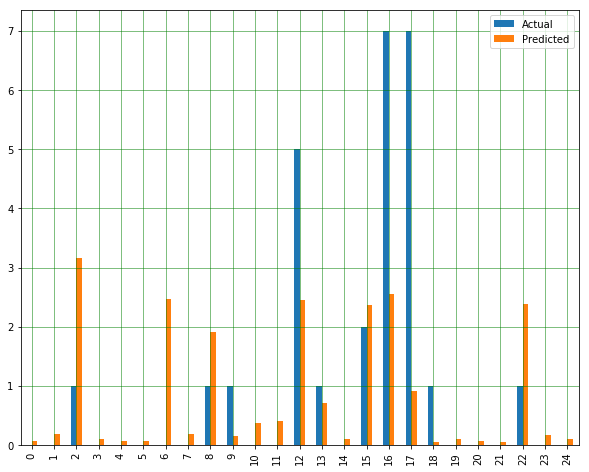

In [21]:
test_df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [22]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('R2 score:', metrics.r2_score(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.0137151487555514
R2 score: 0.3054211266313398
Mean Squared Error: 2.784297164920022
Root Mean Squared Error: 1.6686213365889884


In [23]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(regressor.score(X_train, y_train), 
                                                                                             regressor.oob_score_,
                                                                                             regressor.score(X_val, y_val)))

R^2 Training Score: 0.36 
OOB Score: 0.31 
R^2 Validation Score: 0.30


In [24]:
names = list(X_train.columns)
feature_importances = sorted(zip(map(lambda x: round(x, 4) * 100, regressor.feature_importances_), names), reverse=True)

In [25]:
df_fi = pd.DataFrame(feature_importances, columns=["score", "feature"]) 

In [26]:
df_fi[df_fi["score"] > 0]

,score,feature
0,69.74,minutes_pgw
1,11.21,player_form
2,1.33,opponent_id
3,1.31,player_id
4,1.27,creativity_pgw
5,1.23,team_id
6,1.16,top5_ls
7,0.95,opponent_form
8,0.90,at_home
9,0.87,team_form


In [27]:
filename = '{}-model.pkl'.format(model_type)

In [28]:
gw_dir = os.path.join(os.getcwd(), "..", "model", season, str(gw))

In [29]:
if not os.path.exists(gw_dir):
    os.makedirs(gw_dir)

In [30]:
os.chdir(gw_dir)

In [31]:
with open(filename, 'wb') as file:
    pickle.dump(regressor, file)